<a href="https://colab.research.google.com/github/mattiadido95/Haze-Fog-suppression/blob/main/dataset_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
from google.colab import drive
from google.colab.patches import cv2_imshow
import os
import gdown
import zipfile
import cv2
import numpy as np

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
folder_path = "drive/MyDrive/Haze-Fog-suppression"
os.chdir(folder_path)

# Uncompress Zip files


In [ ]:
os.chdir("dataset")
current_directory = os.getcwd()

#estrae tutti i file zip e cancella il file compresso
for file_name in os.listdir(current_directory):
    if file_name.endswith(".zip"):
        path_to_zip_file = os.path.join(current_directory, file_name)
        with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
            zip_ref.extractall(current_directory)
        os.remove(path_to_zip_file)

# Generate datasets

In [ ]:
#`d` sia l'immagine di profondità e `thresholds` sia una lista di tre soglie
def compute_transmission_map_Koschmieder(d):
    H = d.shape[0]
    W = d.shape[1]
    vector = d.reshape(H * W * 3)
    for pixel_value in vector:
      if pixel_value < 50:
        pixel_value = 0
      elif pixel_value > 50 and pixel_value < 87:
        pixel_value = 50
      elif pixel_value > 87 and pixel_value < 167:
        pixel_value = 87
      elif pixel_value > 167 and pixel_value < 209:
        pixel_value = 167
      else:
        pixel_value = 255
    normalized = vector.reshape(H, W, 3).astype(np.uint8)
    t = np.exp(-0.01 * normalized)
    return t

def compute_transmission_map_Bruneton(d):
  beta = 0.008
  cos_theta = -0.8
  epsilon = 2
  t = np.exp(-beta * d / pow(cos_theta, epsilon))
  return t


In [ ]:
def compute_cevr(original_image,degraded_image):
    max_J = np.max(original_image)
    min_J = np.min(original_image)
    max_I = np.max(degraded_image)
    min_I = np.min(degraded_image)

    cevr = (max_J - min_J) / (max_I - min_I)
    return cevr

In [ ]:
# Specifica i parametri
# Valore di luce atmosferica (generalmente tra 0 e 255)
low_A = 120
medium_A = 180
high_A = 220

low_beta = 0.004
medium_beta = 0.006
high_beta = 0.008
very_high_beta = 0.01

path_to_original_images = "/content/drive/MyDrive/Haze-Fog-suppression/dataset/Vis/"
path_to_depth_maps = "/content/drive/MyDrive/Haze-Fog-suppression/dataset/DepthMaps/"
path_to_input = "/content/drive/MyDrive/Haze-Fog-suppression/dataset/train_A/"
path_to_output = "/content/drive/MyDrive/Haze-Fog-suppression/dataset/train_B/"

In [ ]:
def generate_fog_image(path_to_original_image,path_to_depth_map,A,beta,img_name,level):
    # Carica l'immagine originale e la depth map
    J = cv2.imread(path_to_original_image)
    d = cv2.imread(path_to_depth_map)

    t = np.exp(-beta * d)
    I = J * t + A * (1 - t)

    cv2.imwrite(path_to_input + img_name[:-4] + "_" + str(level) + '.png', np.uint8(I))
    cv2.imwrite(path_to_output + img_name[:-4] + "_" + str(level) + '.png', np.uint8(J))

In [ ]:
# Scorri tutti i file nella cartella
file_ordinati = sorted(os.listdir(path_to_original_images))

for nome_file in file_ordinati[:2100]:
    path_to_original_image = os.path.join(path_to_original_images, nome_file)
    path_to_depth_map = os.path.join(path_to_depth_maps, nome_file)
    generate_fog_image(path_to_original_image,path_to_depth_map,low_A,low_beta,nome_file,"low")
    generate_fog_image(path_to_original_image,path_to_depth_map,medium_A,medium_beta,nome_file,"medium")
    generate_fog_image(path_to_original_image,path_to_depth_map,high_A,high_beta,nome_file,"high")

In [ ]:
# Scorri tutti i file nella cartella
file_ordinati = sorted(os.listdir(path_to_original_images))

for nome_file in file_ordinati[2100:]:
    path_to_original_image = os.path.join(path_to_original_images, nome_file)
    path_to_depth_map = os.path.join(path_to_depth_maps, nome_file)
    generate_fog_image(path_to_original_image,path_to_depth_map,low_A,low_beta,nome_file,"low")
    generate_fog_image(path_to_original_image,path_to_depth_map,medium_A,medium_beta,nome_file,"medium")
    generate_fog_image(path_to_original_image,path_to_depth_map,high_A,high_beta,nome_file,"high")

# Copy file into Pix2PixHD model

In [ ]:
import shutil

# Definisci i percorsi delle cartelle sorgente e destinazione
percorso_sorgente = '/content/drive/MyDrive/Haze-Fog-suppression/dataset/train_A/'
percorso_destinazione = '/content/drive/MyDrive/Haze-Fog-suppression/pix2pixHD/datasets/nebbia/train_A'

# Copia la cartella sorgente nella destinazione
shutil.copytree(percorso_sorgente, percorso_destinazione)


'/content/drive/MyDrive/Haze-Fog-suppression/pix2pixHD/datasets/nebbia/train_A'

In [ ]:
import shutil

# Definisci i percorsi delle cartelle sorgente e destinazione
percorso_sorgente = '/content/drive/MyDrive/Haze-Fog-suppression/dataset/train_B/'
percorso_destinazione = '/content/drive/MyDrive/Haze-Fog-suppression/pix2pixHD/datasets/nebbia/train_B'

# Copia la cartella sorgente nella destinazione
shutil.copytree(percorso_sorgente, percorso_destinazione)


'/content/drive/MyDrive/Haze-Fog-suppression/pix2pixHD/datasets/nebbia/train_B'

In [ ]:
import os

# Definisci il percorso della cartella di destinazione
percorso_destinazione_A = '/content/drive/MyDrive/Haze-Fog-suppression/pix2pixHD/datasets/nebbia/train_A'
percorso_destinazione_B = '/content/drive/MyDrive/Haze-Fog-suppression/pix2pixHD/datasets/nebbia/train_B'

# Stampa il numero di file
print("Il numero totale di file nella cartella train_A è:", len(os.listdir(percorso_destinazione_A)))
print("Il numero totale di file nella cartella train_B è:", len(os.listdir(percorso_destinazione_B)))

Il numero totale di file nella cartella train_A è: 12600
Il numero totale di file nella cartella train_B è: 12600


## delete dataset

In [ ]:
# DANGER
# delete train_A or train_B
import shutil
percorso_cartella_da_eliminare = "/content/drive/MyDrive/Haze-Fog-suppression/pix2pixHD/datasets/nebbia/train_A"
shutil.rmtree(percorso_cartella_da_eliminare)

In [ ]:
shutil.rmtree('/content/drive/MyDrive/Haze-Fog-suppression/pix2pixHD/datasets/nebbia/train_A/.ipynb_checkpoints')
shutil.rmtree('/content/drive/MyDrive/Haze-Fog-suppression/pix2pixHD/datasets/nebbia/train_B/.ipynb_checkpoints')

In [ ]:
file_ordinati = sorted(os.listdir(percorso_destinazione_A))
print(file_ordinati)

['00000_high.png', '00000_low.png', '00000_medium.png', '00001_high.png', '00001_low.png', '00001_medium.png', '00002_high.png', '00002_low.png', '00002_medium.png', '00003_high.png', '00003_low.png', '00003_medium.png', '00004_high.png', '00004_low.png', '00004_medium.png', '00005_high.png', '00005_low.png', '00005_medium.png', '00006_high.png', '00006_low.png', '00006_medium.png', '00007_high.png', '00007_low.png', '00007_medium.png', '00008_high.png', '00008_low.png', '00008_medium.png', '00009_high.png', '00009_low.png', '00009_medium.png', '00010_high.png', '00010_low.png', '00010_medium.png', '00011_high.png', '00011_low.png', '00011_medium.png', '00012_high.png', '00012_low.png', '00012_medium.png', '00013_high.png', '00013_low.png', '00013_medium.png', '00014_high.png', '00014_low.png', '00014_medium.png', '00015_high.png', '00015_low.png', '00015_medium.png', '00016_high.png', '00016_low.png', '00016_medium.png', '00017_high.png', '00017_low.png', '00017_medium.png', '00018_hi

# Resize images


In [ ]:
#Check dimension image ---> fatto in locale perche impiegava troppo tempo

# Definisci il percorso della cartella di destinazione
percorso_destinazione_A = '/content/drive/MyDrive/Haze-Fog-suppression/pix2pixHD/datasets/nebbia/train_A/'
percorso_destinazione_B = '/content/drive/MyDrive/Haze-Fog-suppression/pix2pixHD/datasets/nebbia/train_B/'

file_ordinati = sorted(os.listdir(percorso_destinazione_A))
count=0
file = open("lista_img.txt", "w")
for nome_file in file_ordinati:
    input = os.path.join(percorso_destinazione_A, nome_file)
    output = os.path.join(percorso_destinazione_B, nome_file)
    i = cv2.imread(input)
    o = cv2.imread(output)
    if i.shape != (768, 1024, 3):
      file.write(nome_file + "\n")
    if o.shape != (768, 1024, 3):
      file.write(nome_file + "\n")
    count += 1
    if count % 1000 == 0:
      print(count)
file.close()


KeyboardInterrupt: ignored

['01301.png', '01302.png', '01303.png', '01304.png', '01305.png', '01306.png', '01307.png', '01308.png', '01309.png', '01310.png', '01311.png', '01312.png', '01313.png', '01314.png', '01315.png', '01316.png', '01317.png', '01318.png', '01319.png', '01320.png', '01321.png', '01322.png', '01323.png', '01324.png', '01325.png', '01326.png', '01327.png', '01328.png', '01329.png', '01330.png', '01331.png', '01332.png', '01333.png', '01334.png', '01494.png', '01495.png', '01496.png', '01497.png', '01498.png', '01499.png', '01500.png', '01501.png', '01502.png', '01503.png', '01504.png', '01505.png', '01506.png', '01507.png', '01508.png', '01509.png', '01510.png', '01511.png', '01512.png', '01513.png', '01514.png', '01515.png', '01516.png', '01517.png', '01518.png', '01519.png', '01520.png', '01521.png', '01522.png', '01523.png', '01524.png', '01525.png', '01526.png', '01527.png', '01528.png', '01529.png', '01797.png', '01798.png', '01799.png', '01800.png', '01801.png', '01802.png', '01803.png'

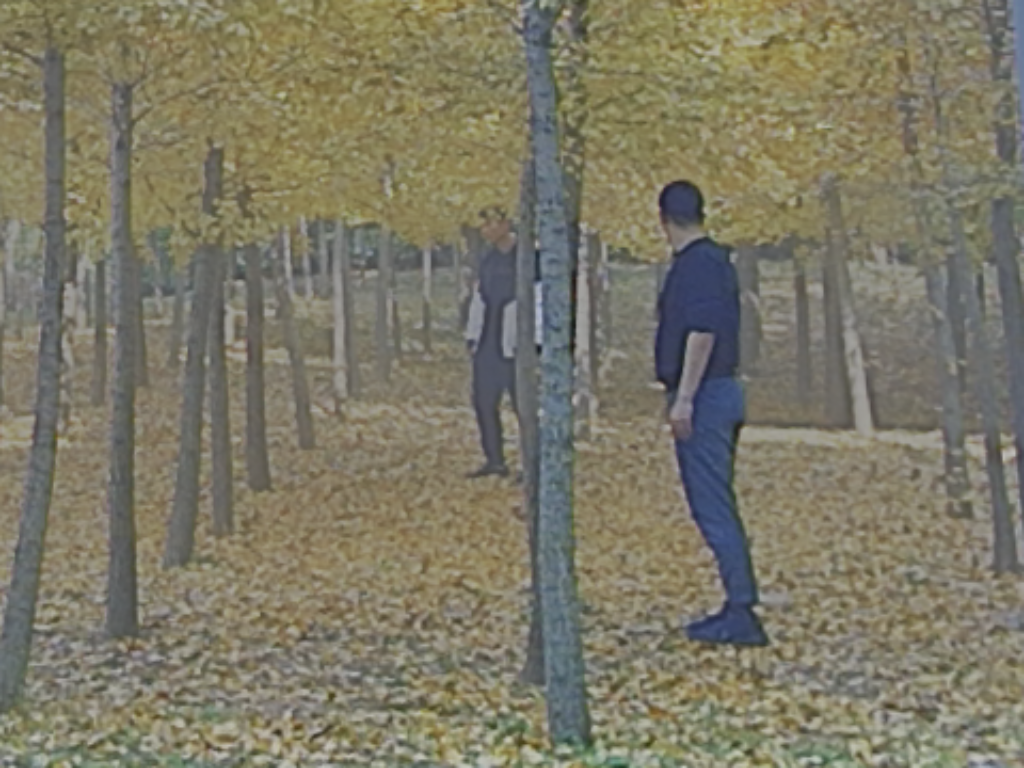

In [4]:
#Resize images already processed

# Definisci il percorso della cartella di destinazione
percorso_destinazione_A = '/content/drive/MyDrive/Haze-Fog-suppression/pix2pixHD/datasets/nebbia/train_A/'
percorso_destinazione_B = '/content/drive/MyDrive/Haze-Fog-suppression/pix2pixHD/datasets/nebbia/train_B/'
new_width = 1024
new_height = 768


#lettura file da modificare
file = open("lista_img.txt", "r")
lines = file.readlines()
lines = [line.rstrip() for line in lines]
file.close()

for nome_file in lines:
  input_low = percorso_destinazione_A + nome_file[:-4] + "_" + 'low.png'
  output_low = percorso_destinazione_B + nome_file[:-4] + "_" + 'low.png'
  input_medium = percorso_destinazione_A + nome_file[:-4] + "_" + 'medium.png'
  output_medium = percorso_destinazione_B + nome_file[:-4] + "_" + 'medium.png'
  input_high = percorso_destinazione_A + nome_file[:-4] + "_" + 'high.png'
  output_high = percorso_destinazione_B + nome_file[:-4] + "_" + 'high.png'

  # Per l'immagine di input di bassa qualità
  image_input_low = cv2.imread(input_low)
  resized_image_input_low = cv2.resize(image_input_low, (new_width, new_height))
  os.remove(input_low)
  cv2.imwrite(input_low, resized_image_input_low)

  # Per l'immagine di output di bassa qualità
  image_output_low = cv2.imread(output_low)
  resized_image_output_low = cv2.resize(image_output_low, (new_width, new_height))
  os.remove(output_low)
  cv2.imwrite(output_low, resized_image_output_low)

  # Per l'immagine di input di media qualità
  image_input_medium = cv2.imread(input_medium)
  resized_image_input_medium = cv2.resize(image_input_medium, (new_width, new_height))
  os.remove(input_medium)
  cv2.imwrite(input_medium, resized_image_input_medium)

  # Per l'immagine di output di media qualità
  image_output_medium = cv2.imread(output_medium)
  resized_image_output_medium = cv2.resize(image_output_medium, (new_width, new_height))
  os.remove(output_medium)
  cv2.imwrite(output_medium, resized_image_output_medium)

  # Per l'immagine di input di alta qualità
  image_input_high = cv2.imread(input_high)
  resized_image_input_high = cv2.resize(image_input_high, (new_width, new_height))
  os.remove(input_high)
  cv2.imwrite(input_high, resized_image_input_high)

  # Per l'immagine di output di alta qualità
  image_output_high = cv2.imread(output_high)
  resized_image_output_high = cv2.resize(image_output_high, (new_width, new_height))
  os.remove(output_high)
  cv2.imwrite(output_high, resized_image_output_high)


In [11]:
file = open("lista_img.txt", "r")
lines = file.readlines()
lines = [line.rstrip() for line in lines]
print(lines)
file.close()

['01301.png', '01302.png', '01303.png', '01304.png', '01305.png', '01306.png', '01307.png', '01308.png', '01309.png', '01310.png', '01311.png', '01312.png', '01313.png', '01314.png', '01315.png', '01316.png', '01317.png', '01318.png', '01319.png', '01320.png', '01321.png', '01322.png', '01323.png', '01324.png', '01325.png', '01326.png', '01327.png', '01328.png', '01329.png', '01330.png', '01331.png', '01332.png', '01333.png', '01334.png', '01494.png', '01495.png', '01496.png', '01497.png', '01498.png', '01499.png', '01500.png', '01501.png', '01502.png', '01503.png', '01504.png', '01505.png', '01506.png', '01507.png', '01508.png', '01509.png', '01510.png', '01511.png', '01512.png', '01513.png', '01514.png', '01515.png', '01516.png', '01517.png', '01518.png', '01519.png', '01520.png', '01521.png', '01522.png', '01523.png', '01524.png', '01525.png', '01526.png', '01527.png', '01528.png', '01529.png', '01797.png', '01798.png', '01799.png', '01800.png', '01801.png', '01802.png', '01803.png'